In [2]:
import numpy as np
import pandas as pd
from collections import Counter
import matplotlib.pyplot as plt
plt.style.use('ggplot')

# A Game of Dice: Farkle!
Growing up, Farkle was a camping trip tradition of my grandparents. Every evening after putting out the fire, we would retreat to my grandparents' camper and pull out the dice for a few rounds. It is a simple game largely governed by chance, yet none-the-less each person seems to have their own strategy. Some people like to gamble, others play it safe. In this post we take a statistical approach to analyzing strategy and see how it compares with our intuition.

## Rules of Play
The rules of the game vary widely, but we will consider a specific case here. The player starts by rolling six dice. The player sets aside dice that are worth points and rolls the remaining dice.  A few important points:
1. At least one dice must be set aside after each roll. 
2. If you can set aside all six dice, then you can roll them all again to continue building up your total. 
3. A **Farkle** occurs when there are no combinations of dice that are worth points. In this case, you lose all points accumulated that turn and your turn is over. 
4. You may stop rolling at anytime during your turn, in which case your total gets entered on the score sheet and your turn is over. 
5. The first player to 10,000 points is declared the winner and gets bragging rights until the next game. 

There are a couple technical points that don't affect what we will investigate here, but I mention them for completeness. First, to score for the first time you must score at least 500 points before you stop rolling. This is referred to as 'getting on the board'. Second, once somebody breaks 10,000 points and decides to stop rolling, every other play gets one more turn to try to break that score. If they can do so, then they are declared winner instead.

## Scoring Combinations
Different dice combinations are worth various points. Here is a complete list of scoring combinations.

| Dice Combination | Points | Dice Combination | Points
| :- | :- | :- | :- |
| 6 of  a kind | 3,000 | 4 of a kind with a pair | 1,500
| Two triplets | 2,500 | 4 of a kind | 1,000
| 5 of a kind | 2,000 | 3 of a kind (excluding 1) | 100$\times$value of dice
| 1-6 straight | 1,500 | Single 1 | 100
| 3 pairs | 1,500 | Single 5 | 50

## Risk Strategy
The universal question of Farkle players: when to stop rolling? Here are a couple limiting cases to illustrate the scope of the question.
- **Limiting Case #1** It's the beginning of your turn and you roll all six dice. You can only set aside a single 5, worth 50 points. You have 5 dice left. What do you do? The obvious choice is to keep rolling. With five dice left, you are likely to accrue more points.
- **Limiting Case #2** You are several rolls into your turn and have accumulated 3,000 points&mdash;an impressive sum!. You only have one dice available to roll. Should you roll it and risk a Farkle (thereby flushing your bounty down the drain), or should you call it and take your 3,000 points? The obvous answer is to stop rolling! Speaking from experience, it's not very common to get to 3,000 points, and you are more likely than not to Farkle with only one dice being rolled.

These are the obvious limiting cases, but what about the cases in the middle? Suppose you have 450 points and have 3 dice left to roll, what should you do? This is the question we seek to answer here.

One approach to this is to calculate the probability of a Farkle given that you are rolling a given number of dice. With these probabilities known, one simply needs to decide on a risk tolerence. For example, maybe you decide to never roll if the probability of a Farkle is greater than 10\%. Note that in this strategy your current accrued total is irrelevant to your decision. 

Although we will calculate the probabilities of a Farkle later on, they are only a small part of the whole story. When deciding whether to roll, players invariable take into account their totals. For example, it is common for someone to roll just two dice when they have accrued only 200 points, but when having accrued 2500 points will decide that rolling five dice is too risky. The question we want to answer here is, what is an "average" single-turn total?

## Hacker Statistics
To answer this question, we will employ a simple strategy. We will play the game many many times, however we will play it a little bit differently. First, there is only one player in this game. Second, there is only one turn per game. Finally, this player is a gambling addict! They keep rolling, whatever the odds, until they Farkle. The player then jots down what score they had before the Farkle occurred. If the player does this millions of times, then we should get a clear idea of what single-turn scores are likely and which are unlikely.

## Decision Trees
Before doing this, we have to set some standards for decision making. Different people have different 'strategies' and risk tolerances. Here I lay out how the decisions are to be made here.

Suppose we just rolled the dice. We start by looking at the most lucrative combinations and work our way downward. For each combination, we check if it is present in our roll. If it is, then we decide whether or not to accept it. For the first several entries, there is no ambiguity. If you have 6 of a kind, then always take it! 

Abmiguity begins to appear when we are looking at the 3 of a kinds and below. I have met people that, faced with three ones, will prefer to set aside a single one for 100 points and reserve the remaining two dice for future rolls. Our gambler will implement the following decision tree after each roll:
- Starting from the most lucrative combination in the table above and going down to 3 of a kinds, we check to see if that combination is present in our roll. If so, we take it and set aside the appropriate dice.
- We always take a 3 of a kind if present and there's nothing more lucrative.
- We always take all 1's that are present if there's nothing more lucrative.
- If nothing else is available, but there is at least one 5, then we take exactly one 5. We reserve the remaing dice for future rolls. The exception to this rule is if by taking all fives, we are able to set aside all of the dice and continue rolling with all six. 

We have defined an object that plays a single game as described above using this decision tree. The code can be found in `Farkle.py`. Feel free to take a peak!

In [3]:
import Farkle

## Let's play!
We play 100000 games and look at the scores before Farkles occurred, as well as the number of times a given scoring combination was accepted. To organize the results, we will store everything in a numpy array object, which will later be converted to a pandas data frame. For each row, the first entry will be the score and the remaining entries will be the scoring combinations in the same order listed in the table above.

In [4]:
n_games = 100000 # cell takes a minute to run for n_games = 10^6
data_arr = np.zeros((n_games, 11))

for i in range(n_games):
    Roll = Farkle.FarkleRoll()
    data_arr[i] = Roll.play()
    i += 1

attr = list(Roll.__dict__.keys())
column_names = [attr[0]] + attr[4:]
df = pd.DataFrame(data=data_arr, columns=column_names)

We plot a histogram of the number of scores below. We initially restrict the graph to scores below 1000. This is done because 1) it makes the graph easier to read and 2) scores greater than 1000 are outliers (speaking from personal experience).

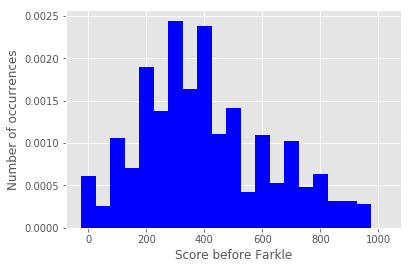

In [5]:
filtered = [x for x in df['score'] if x<1000]

bins = np.arange(0, max(filtered)+150, 50)-25
_ = plt.hist(filtered, bins=bins, color='blue', density=True)
_ = plt.xlabel('Score before Farkle')
_ = plt.ylabel('Number of occurrences')

In [92]:
print('Standard deviation of scores = {}'.format(np.std(df['score'])))

Standard deviation of scores = 789.0181726358657


From the histogram, we see that the most common scores are 300 and 400. How does this affect your Farkle play? Well, if you are below 300 points on your current turn, it's best to keep rolling. Conversely, if you have 500 points and only one dice left to roll, it's in your better interest to stay where you are!

Will this help you win?! Probably not... The standard deviation of the distribution is ~750, and remember: that's *per turn*. Unless you and your friends decide to play best out of $10^6$ games, random fluctations are likely to determine the winner :(

## The Tails
We zoom out and look at the entire distribution. As one might expect, the distribution of scores falls off exponentially beyond approximatly 400.

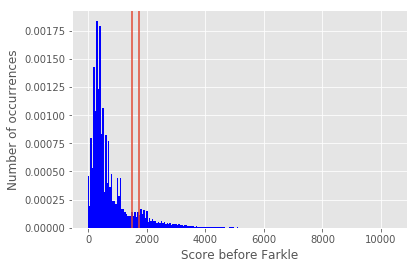

In [6]:
bins = np.arange(0, max(df['score'])+150, 50)-25
_ = plt.hist(df['score'], bins=bins, color='blue', density=True)
_ = plt.xlabel('Score before Farkle')
_ = plt.ylabel('Number of occurrences')
plt.axvline(x=1750)
plt.axvline(x=1500)

An interesting featuer is the hump just below 2000 points. We have dropped a couple vertical lines to guide the eye. This suggests that it is more probable to score 1750 than it is to score 1500. The mechanism behind this peak isn't clear, but it is none-the-less persistent.

## Workhorse combinations and correlations
We can dig a little deeper into the data and search for the scoring combinations that produce the most points. We know that a six of a kind will give us the most points in a single roll, but you're not very likely to roll such a combination. We start by plotting the total score versus the number of various scoring combinations.

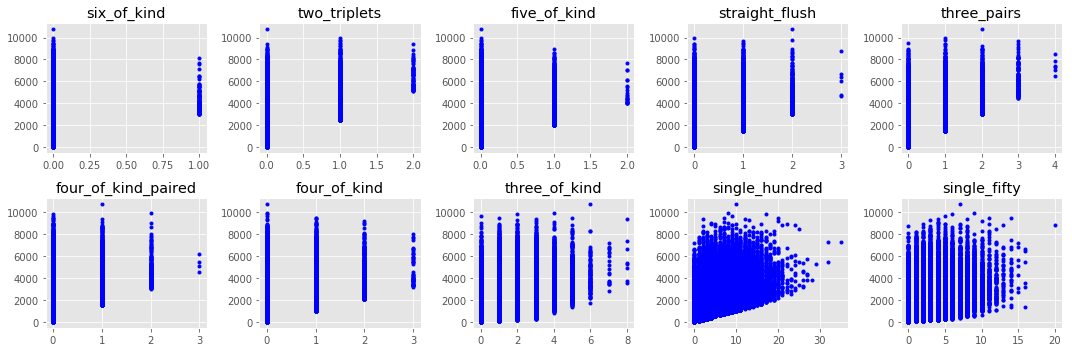

In [94]:
fig, axes = plt.subplots(2,5,figsize=(15, 5))
for i, ax in enumerate(axes.flatten()):
    _ = ax.plot(df[column_names[i+1]].values, df['score'].values, marker='.', linestyle='none', color='blue')
    _ = ax.set_title(column_names[i+1])
plt.tight_layout()

A prominent feature in these plots is the slope seen along the *bottom* of the points. Namely, as one accrues more of a certain combination, the minimum score increases. The reason for this feature is the following: if I rolled a six of a kind in my turn, then my total accrued points before Farkling is at least 3,000. Indeed, we can check this against the numerics:

In [7]:
val = df[df.six_of_kind==1]['score'].values.min()
print('Minimum score when a six of a kind was rolled: {}'.format(int(val)))

Minimum score when a six of a kind was rolled: 3200


Similarly, everytime I roll a four of a kind with a pair, I accrue 1,500 points. Thus, if I roll two of them, then I will have at least $2\times 1500=3000$ points. Checking this against the numerics:

In [8]:
val = df[df.four_of_kind_paired==2]['score'].values.min()
print('Minimum score when a four of a kind with a pair was rolled: {}'.format(int(val)))

Minimum score when a four of a kind with a pair was rolled: 3050


### Correlations
We can also look at how the number of occurrences of a given scoring combination correlate with the total score before Farkling. Below we plot the Pearson correlation coefficient bewteen the score and the number of each combination obtained.

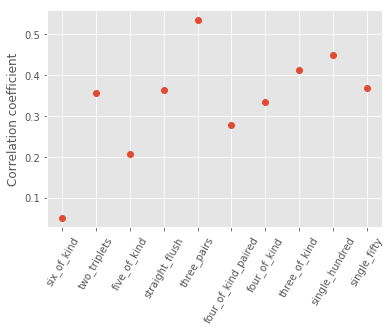

<Figure size 432x288 with 0 Axes>

In [9]:
corr = df.corr()
_ = plt.plot(corr['score'][1:], marker='o', linestyle='none')
_ = plt.xticks(range(len(corr)-1), corr.columns[1:], rotation=60)
_ = plt.ylabel('Correlation coefficient')
plt.show()
plt.tight_layout()

### The three pairs anamoly
The most surprising feature in the above graph is that the scoring combination that correlates best with the score is three pairs. *Why three pairs?!* This appears at first sight to be completely random, and yet if you rerun the simulation you will find that this feature persists. 

### Probabilities and specific returns
Let is look at the "probability" of rolling any of the combinations. We put quotations around the word 'probability' because we don't always take a scoring combination when it is rolled. Indeed, we only take single 5's a subset of the time they are rolled. Thus, what we are really looking at is the fraction of the time we accept a given scoring combination. These probabilities will ostensibly change if one were to follow a different decision tree.

six_of_kind            0.000037
two_triplets           0.002229
five_of_kind           0.001387
straight_flush         0.005139
three_pairs            0.012556
four_of_kind_paired    0.003255
four_of_kind           0.015684
three_of_kind          0.144165
single_hundred         0.573474
single_fifty           0.242074
dtype: float64


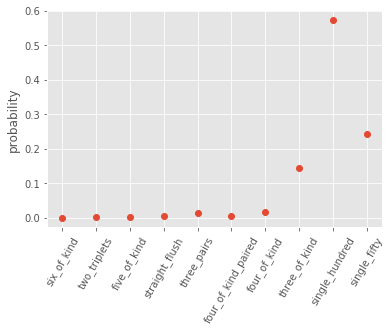

In [10]:
counts = df.loc[:, df.columns != 'score'].sum()
probs = counts / counts.values.sum()
print(probs)
plt.figure()
_ = plt.plot(np.arange(10), probs.values, marker='o', linestyle='none')
_ = plt.xticks(np.arange(10), df.columns[1:], rotation=60)
_ = plt.ylabel('probability')

We next weight each probability by the points possible. The result is essentially an expected return for a given scoring combination and so we will call it the specific expected return (SER). Note that the SER for three of a kinds is not unique, since it depends on which dice comprise the three of a kind. The return can be one of 200, 300, 400, 500, or 600, with equal probability. Because they are all equally probable, we will weight three of a kinds with the average:
$$
  \frac{200+300+400+500+600}{5} = 400.
$$

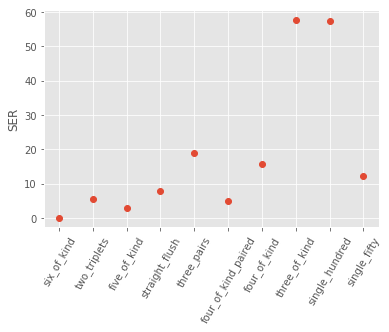

In [13]:
weights = np.array([3000, 2500, 2000, 1500, 1500, 1500, 1000, 400, 100, 50])
specific_returns = probs*weights

plt.figure()
_ = plt.plot(np.arange(10), specific_returns.values, marker='o', linestyle='none')
_ = plt.xticks(np.arange(10), df.columns[1:], rotation=60)
_ = plt.ylabel('SER')

The graph above has some meat to it, so let's remember what we have done. We have taken the the fraction of rolls that we collect a given scoring combo and have multiplied it by the points earned for that scoring combination. Thus, the SERs are a measure of the contribution of each scoring combination to our total score. Indeed, by summing the SERs, we obtain the expected value of points for a single roll:

In [12]:
print("Expected value for single roll is {}".format(weighted.sum()))

NameError: name 'weighted' is not defined

## More to Come!
There are a couple direction one could take with this.
1. How do modifications in the decision tree affect the distribution?
2. How many games does one have to play before slight differences in strategy can be resolve?

As always, I'm eager for feedback. If the code can be cleaned up, if there are important items I neglected, or if there are interesting directions of inquiry that I passed by, let me know!